<a href="https://colab.research.google.com/github/akari2951/Telco-customer-churn/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ライブラリインポート

In [1]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=ab0799fd7c49418927623ca356112fe0e584f0d39033f105a972fff58938c3cd
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import lifelines
from lifelines import CoxPHFitter
from lifelines.utils import ConvergenceError
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree


## Data download  
https://www.kaggle.com/datasets/waseemalastal/telco-customer-churn-ibm-dataset をダウンロード

In [3]:
from google.colab import files

# kaggle.jsonをアップロード
files.upload()

import os
import shutil

# kaggle.json を ~/.kaggle に移動
os.makedirs("/root/.kaggle", exist_ok=True)

# 既存の kaggle.json があれば削除
kaggle_json_path = "/root/.kaggle/kaggle.json"
if os.path.exists(kaggle_json_path):
    os.remove(kaggle_json_path)

# kaggle.json を ~/.kaggle に移動
shutil.move("kaggle.json", kaggle_json_path)

# 権限を設定
os.chmod(kaggle_json_path, 600)


Saving kaggle.json to kaggle.json


In [4]:
# kaggleデータセットをダウンロード
!kaggle datasets download -d waseemalastal/telco-customer-churn-ibm-dataset

Dataset URL: https://www.kaggle.com/datasets/waseemalastal/telco-customer-churn-ibm-dataset
License(s): DbCL-1.0


In [5]:
# # データセットの解答
import zipfile

# ダウンロードしたzipファイルを解凍
with zipfile.ZipFile("telco-customer-churn-ibm-dataset.zip", "r") as z:
    z.extractall("telco-customer-churn-ibm-data")

# 解凍後のファイル一覧を確認
os.listdir()


['.config',
 'telco-customer-churn-ibm-data',
 'telco-customer-churn-ibm-dataset.zip',
 'sample_data']

In [6]:
# ディレクトリの階層をすべて確認
for root, dirs, files in os.walk("telco-customer-churn-ibm-data"):
    print(root, files)


telco-customer-churn-ibm-data []
telco-customer-churn-ibm-data/Telco_customer_churn_IBM_dataset ['Telco_customer_churn.xlsx']


## DataFrame check

In [7]:
# 確認した内容をもとにデータセットファイルを読み込む
df = pd.read_excel("telco-customer-churn-ibm-data/Telco_customer_churn_IBM_dataset/Telco_customer_churn.xlsx")
print(df.head())
print(df.shape)

   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Tota

In [8]:
# データタイプの確認
df.dtypes

,0
CustomerID,object
Count,int64
Country,object
State,object
City,object
Zip Code,int64
Lat Long,object
Latitude,float64
Longitude,float64
Gender,object


Total Chargesは「顧客に請求される合計金額」を示すとデータセット概要に記載があるため、データ型はint型かfloat型が想定されます。  
しかしobject型となっているため、float型に変換処理を加えます。

In [9]:
# データ型を変換
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
print(df["Total Charges"].dtypes)


float64


In [10]:
# データフレームの欠損値（NaN）の個数をカウント
df.isnull().sum()

,0
CustomerID,0
Count,0
Country,0
State,0
City,0
Zip Code,0
Lat Long,0
Latitude,0
Longitude,0
Gender,0


In [11]:
# データ型がobjectのデータフレームを抽出
df_object = df.select_dtypes(include="object")
print(df_object.head(3))

   CustomerID        Country       State         City                Lat Long  \
0  3668-QPYBK  United States  California  Los Angeles  33.964131, -118.272783   
1  9237-HQITU  United States  California  Los Angeles   34.059281, -118.30742   
2  9305-CDSKC  United States  California  Los Angeles  34.048013, -118.293953   

   Gender Senior Citizen Partner Dependents Phone Service  ... Online Backup  \
0    Male             No      No         No           Yes  ...           Yes   
1  Female             No      No        Yes           Yes  ...            No   
2  Female             No      No        Yes           Yes  ...            No   

  Device Protection Tech Support Streaming TV Streaming Movies  \
0                No           No           No               No   
1                No           No           No               No   
2               Yes           No          Yes              Yes   

         Contract Paperless Billing    Payment Method Churn Label  \
0  Month-to-month   

### data processing

In [12]:
from sklearn.preprocessing import LabelEncoder

def object_to_int_with_mapping(dataframe_series):
    if dataframe_series.dtype == 'object':
        le = LabelEncoder()
        dataframe_series = dataframe_series.astype(str)  # 念のため文字列化
        le.fit(dataframe_series)  # 変換ルールを学習
        mapping = {key: int(value) for key, value in zip(le.classes_, le.transform(le.classes_))}
        return dataframe_series.map(mapping), mapping  # 変換したデータとマッピングを返す
    else:
        return dataframe_series, None  # 変換なし

# 変換とマッピングの取得
encoded_columns = {}
for col in df_object.select_dtypes(include='object').columns:
    df_object[col], encoded_columns[col] = object_to_int_with_mapping(df_object[col])

# 変換マッピングを表示
for col, mapping in encoded_columns.items():
    print(f"\nカラム: {col}")
    print(mapping)



カラム: CustomerID
{'0002-ORFBO': 0, '0003-MKNFE': 1, '0004-TLHLJ': 2, '0011-IGKFF': 3, '0013-EXCHZ': 4, '0013-MHZWF': 5, '0013-SMEOE': 6, '0014-BMAQU': 7, '0015-UOCOJ': 8, '0016-QLJIS': 9, '0017-DINOC': 10, '0017-IUDMW': 11, '0018-NYROU': 12, '0019-EFAEP': 13, '0019-GFNTW': 14, '0020-INWCK': 15, '0020-JDNXP': 16, '0021-IKXGC': 17, '0022-TCJCI': 18, '0023-HGHWL': 19, '0023-UYUPN': 20, '0023-XUOPT': 21, '0027-KWYKW': 22, '0030-FNXPP': 23, '0031-PVLZI': 24, '0032-PGELS': 25, '0036-IHMOT': 26, '0040-HALCW': 27, '0042-JVWOJ': 28, '0042-RLHYP': 29, '0048-LUMLS': 30, '0048-PIHNL': 31, '0052-DCKON': 32, '0052-YNYOT': 33, '0056-EPFBG': 34, '0057-QBUQH': 35, '0058-EVZWM': 36, '0060-FUALY': 37, '0064-SUDOG': 38, '0064-YIJGF': 39, '0067-DKWBL': 40, '0068-FIGTF': 41, '0071-NDAFP': 42, '0074-HDKDG': 43, '0076-LVEPS': 44, '0078-XZMHT': 45, '0080-EMYVY': 46, '0080-OROZO': 47, '0082-LDZUE': 48, '0082-OQIQY': 49, '0083-PIVIK': 50, '0089-IIQKO': 51, '0093-EXYQL': 52, '0093-XWZFY': 53, '0094-OIFMO': 54, '0

In [13]:
# df, df_objectを重複カラムなしで結合
df_numeric = df.select_dtypes(exclude="object")
df_concat = pd.concat([df_numeric, df_object], axis=1)
print(df_concat.head())
# print(df_concat.columns)

   Count  Zip Code   Latitude   Longitude  Tenure Months  Monthly Charges  \
0      1     90003  33.964131 -118.272783              2            53.85   
1      1     90005  34.059281 -118.307420              2            70.70   
2      1     90006  34.048013 -118.293953              8            99.65   
3      1     90010  34.062125 -118.315709             28           104.80   
4      1     90015  34.039224 -118.266293             49           103.70   

   Total Charges  Churn Value  Churn Score  CLTV  ...  Online Backup  \
0         108.15            1           86  3239  ...              2   
1         151.65            1           67  2701  ...              0   
2         820.50            1           86  5372  ...              0   
3        3046.05            1           84  5003  ...              0   
4        5036.30            1           89  5340  ...              2   

   Device Protection  Tech Support  Streaming TV  Streaming Movies  Contract  \
0                  0    

In [14]:
# データフレームの要素Nanを含む行を削除
df_concat = df_concat.dropna()
print(df_concat.shape)

(7032, 33)


Nanを含む行を削除したので、元々のデータフレームが保持していた7043行から7032行に縮小されたことを確認。

In [15]:
# データフレームの特徴量を確認
df_concat.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV,...,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Churn Label,Churn Reason
count,7032.0,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,1.0,93523.032565,36.283307,-119.799215,32.421786,64.798208,2283.300441,0.265785,58.715301,4401.445108,...,0.905859,0.903868,0.796359,0.984926,0.992890,0.688567,0.592719,1.573237,0.265785,16.707196
std,0.0,1865.515958,2.456118,2.157588,24.545260,30.085974,2266.771362,0.441782,21.531321,1182.414266,...,0.880394,0.880178,0.861674,0.885285,0.885385,0.832934,0.491363,1.067504,0.441782,6.297897
min,1.0,90001.000000,32.555828,-124.301372,1.000000,18.250000,18.800000,0.000000,5.000000,2003.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.587500,401.450000,0.000000,40.000000,3469.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000
50%,1.0,93552.500000,36.391777,-119.735410,29.000000,70.350000,1397.475000,0.000000,61.000000,4527.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,20.000000
75%,1.0,95354.000000,38.227285,-118.043237,55.000000,89.862500,3794.737500,1.000000,75.000000,5381.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,20.000000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,8684.800000,1.000000,100.000000,6500.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,20.000000


In [16]:
print(df_concat.columns)

Index(['Count', 'Zip Code', 'Latitude', 'Longitude', 'Tenure Months',
       'Monthly Charges', 'Total Charges', 'Churn Value', 'Churn Score',
       'CLTV', 'CustomerID', 'Country', 'State', 'City', 'Lat Long', 'Gender',
       'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Churn Label', 'Churn Reason'],
      dtype='object')


データフレームの特徴量を確認し、今回解析に使わない以下のカラムをデータフレームから削除します。  
'Count', 'Zip Code', 'Latitude', 'Longitude',
'CustomerID', 'Country', 'State', 'City', 'Lat Long','Contract'

In [17]:
# 今回解析に使わないカラムを削除
columns_to_drop = ['Count', 'Zip Code', 'Latitude', 'Longitude',
       'CustomerID', 'Country', 'State', 'City', 'Lat Long','Contract']
df_concat = df_concat.drop(columns=columns_to_drop)
df_concat.columns

Index(['Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'Churn Score', 'CLTV', 'Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Paperless Billing',
       'Payment Method', 'Churn Label', 'Churn Reason'],
      dtype='object')

In [18]:
# データフレームの相関関係を確認
corr_matrix = df_concat.corr()
print(corr_matrix)
# corr_matrix

                   Tenure Months  Monthly Charges  Total Charges  Churn Value  \
Tenure Months           1.000000         0.246862       0.825880    -0.354049   
Monthly Charges         0.246862         1.000000       0.651065     0.192858   
Total Charges           0.825880         0.651065       1.000000    -0.199484   
Churn Value            -0.354049         0.192858      -0.199484     1.000000   
Churn Score            -0.226379         0.133556      -0.124312     0.664970   
CLTV                    0.396188         0.098565       0.341837    -0.128253   
Gender                  0.005285        -0.013779       0.000048    -0.008545   
Senior Citizen          0.015683         0.219874       0.102411     0.150541   
Partner                 0.381912         0.097825       0.319072    -0.149982   
Dependents              0.133773        -0.142926       0.032184    -0.248140   
Phone Service           0.007877         0.248033       0.113008     0.011691   
Multiple Lines          0.34

In [19]:
# plotly で相関行列のヒートマップを描画します。
fig = go.Figure(
    data=go.Heatmap(
        z=corr_matrix.values,  # 相関行列の値
        x=corr_matrix.columns,  # X軸ラベル（カラム名）
        y=corr_matrix.index,    # Y軸ラベル（インデックス）
        colorscale="RdBu_r",    # カラーマップ
        zmin=-1, zmax=1,        # 相関値の範囲（-1 ～ 1）
        text=corr_matrix.values.round(2),  # テキストで相関値を表示
        hoverinfo="text"        # ホバー時に相関値を表示
    )
)

# レイアウト設定
fig.update_layout(title="Correlation Matrix Heatmap",
                  xaxis=dict(title="Features"),
                  yaxis=dict(title="Features"),
                  width=600, height=600)

fig.show()

グラフから相関係数が特に高い組み合わせは以下だと分かります。  
・Churn Reason, Churn Value  
・Total Charges, Tenure Months  

生存時間解析では説明変数の間に高い相関があると多重共線性が発生する可能性があります。  
これにより、モデルがこれらの特徴量の間でどの変数がどれくらいの影響を与えているかを識別するのが困難になるため、  
相関係数が高い組み合わせのうち片方のカラムをデータフレームから削除した新たなデータフレームを作成します。  

※多重共線性とは、2つ以上の説明変数が非常に強い相関を持っている状況を指します。

In [20]:
surv_df = df_concat.drop(columns=["Churn Value", "Total Charges",])
print(surv_df.columns)

Index(['Tenure Months', 'Monthly Charges', 'Churn Score', 'CLTV', 'Gender',
       'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Paperless Billing', 'Payment Method',
       'Churn Label', 'Churn Reason'],
      dtype='object')


### Data Visualization

In [21]:
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']
# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=df['Gender'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=df['Churn Label'].value_counts(), name="Churn"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=20)

fig.update_layout(
    title_text="Gender and Churn Distributions",
    legend_font=dict(size=16),
    title_font=dict(size=27),
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Gender', x=0.20, y=0.5, font_size=24, showarrow=False),
                 dict(text='Churn', x=0.80, y=0.5, font_size=24, showarrow=False)])
fig.show()

男女比＝50.5 : 49.5  
解約者は73.5%, サービス継続者は26.5% だということが分かりました。

In [22]:
fig = px.histogram(df_object, x="Churn Label", color="Contract", barmode="group", title="<b>Customer contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1, title_font=dict(size=27), xaxis_title_font=dict(size=20),yaxis_title_font=dict(size=20), legend_font=dict(size=18))
fig.show()

Contract: 顧客の契約タイプ (月単位=0 / 1年=1 / 2 年=2)  
Churn Label: 顧客が解約したかどうか (はい=1 / いいえ=0)  を示すことから、  
解約した人は年単位で契約している傾向がうかがえます。

In [23]:
fig = px.histogram(df_object, x="Churn Label", color="Partner", barmode="group", title="<b>Customer contract distribution2<b>")
fig.update_layout(width=700, height=500, bargap=0.1, title_font=dict(size=27), xaxis_title_font=dict(size=20),yaxis_title_font=dict(size=20), legend_font=dict(size=18))
fig.show()

Partner: 顧客にパートナーがいるかどうか (はい=1/いいえ=0)  
Churn Label: 顧客が解約したかどうか (はい=1/いいえ=0) を示すことから、  
解約した人はパートナーがいない傾向がうかがえます。

### 生存時間解析

Iteration 1: norm_delta = 2.10e+00, step_size = 0.9500, log_lik = -15653.03964, newton_decrement = 4.14e+03, seconds_since_start = 0.0
Iteration 2: norm_delta = 2.48e+00, step_size = 0.9500, log_lik = -13727.16461, newton_decrement = 1.72e+03, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.80e+00, step_size = 0.9500, log_lik = -14322.96342, newton_decrement = 2.35e+03, seconds_since_start = 0.0
Iteration 4: norm_delta = 8.67e-01, step_size = 0.9310, log_lik = -13021.57709, newton_decrement = 3.92e+02, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.14e-01, step_size = 1.0000, log_lik = -12775.39973, newton_decrement = 6.16e+01, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.74e-02, step_size = 1.0000, log_lik = -12711.76454, newton_decrement = 2.64e-01, seconds_since_start = 0.1
Iteration 7: norm_delta = 2.12e-04, step_size = 1.0000, log_lik = -12711.49870, newton_decrement = 2.46e-05, seconds_since_start = 0.1
Iteration 8: norm_delta = 3.71e-08, step_size = 1.0000,

<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'Tenure Months'
                event col = 'Churn Label'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -12711.50
         time fit was run = 2025-04-02 23:47:47 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Monthly Charges    0.00      1.00      0.00            0.00            0.01                1.00                1.01
Churn Score        0.04      1.04      0.00            0.04            0.05                1.04                1.05
CLTV              -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Gender            -0.09      0.92      0.05           -0.18            0.00                0.84                1.00
Senior Citizen    -0.10      0.91      0.06           -0.21            0.01                0.81                1.01
Partner           -0.50      0.61      0.05           -0.60           -0.40                0.55                0.67
Dependents        -0.34      0.71      0.11           -0.55           -0.13                0.58                0.88
Phone Service     -0.05      0.95      0.12           -0.28            0.18                0.75                1.20
Multiple Lines    -0.27      0.76      0.03           -0.33           -0.22                0.72                0.80
Internet Service   0.00      1.00      0.05           -0.10            0.11                0.90                1.11
Online Security   -0.27      0.76      0.03           -0.34           -0.21                0.71                0.81
Online Backup     -0.29      0.75      0.03           -0.35           -0.24                0.71                0.79
Device Protection -0.21      0.81      0.03           -0.26           -0.15                0.77                0.86
Tech Support      -0.27      0.76      0.03           -0.34           -0.21                0.71                0.81
Streaming TV      -0.17      0.84      0.03           -0.23           -0.12                0.79                0.89
Streaming Movies  -0.18      0.83      0.03           -0.24           -0.12                0.79                0.88
Paperless Billing  0.05      1.05      0.06           -0.06            0.16                0.94                1.17
Payment Method     0.30      1.35      0.03            0.25            0.36                1.28                1.43
Churn Reason      -0.10      0.90      0.00           -0.11           -0.10                0.89                0.91

                   cmp to      z      p  -log2(p)
covariate                                        
Monthly Charges      0.00   2.39   0.02      5.89
Churn Score          0.00  22.82 <0.005    380.44
CLTV                 0.00  -7.65 <0.005     45.45
Gender               0.00  -1.87   0.06      4.03
Senior Citizen       0.00  -1.79   0.07      3.76
Partner              0.00  -9.78 <0.005     72.65
Dependents           0.00  -3.15 <0.005      9.25
Phone Service        0.00  -0.41   0.68      0.56
Multiple Lines       0.00  -9.94 <0.005     74.94
Internet Service     0.00   0.04   0.97      0.05
Online Security      0.00  -8.20 <0.005     51.83
Online Backup        0.00 -10.53 <0.005     83.70
Device Protection    0.00  -7.37 <0.005     42.39
Tech Support         0.00  -8.07 <0.005     50.39
Streaming TV         0.00  -6.00 <0.005     28.92
Streaming Movies     0.00  -6.22 <0.005     30.87
Paperless Billing    0.00   0.84   0.40      1.31
Payment Method       0.00  10.73 <0.005     86.79
Churn Reason         0.00 -25.63 <0.005    478.81
---
Concordance = 0.93
Partial AIC = 25461.00
log-likelihood ratio test = 5883.08 on 19 df
-log2(p) of ll-ratio test = inf


cph.plot()


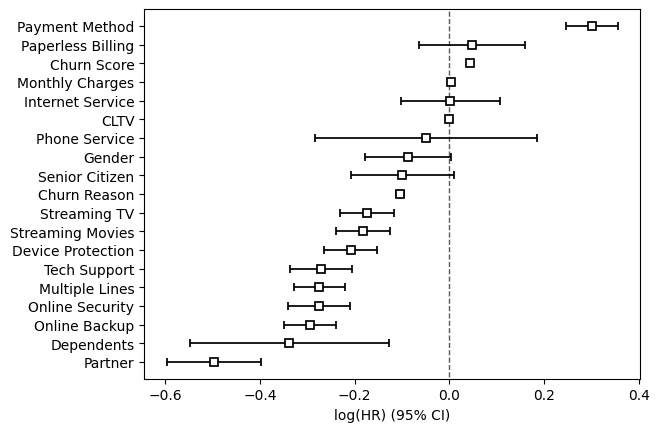

In [24]:
# Cox比例ハザードモデルの適用
cph = CoxPHFitter()

try:
  cph.fit(surv_df, duration_col='Tenure Months', event_col='Churn Label', show_progress=True,)
  # モデルの要約を表示
  print("cph.print_summary()")
  cph.print_summary()
  print()

  # 生存曲線のプロット
  print("cph.plot()")
  cph.plot()
except ConvergenceError as e:
  print(f"収束エラーが発生しました。：{e}")

この結果から、**説明変数のPayment MethodとPartner に解約するまでの期間が影響を受けている**ことが以下の見方から分かります。

cph.print_summary()で出力される表では、  
exp(coef), p値に注目します。  
exp(coef)：ハザード比を示しており1から遠ざかる値程、解約するまでの期間に影響を与える説明変数だと解釈します。  
p値：有意水準が0.05より小さい値だと、exp(coef)が有効になると考えます。  

説明変数 | exp(coef) | p  
--- |--- |--- |
Payment Method | 1.35 | <0.005
Partner | 0.61 | <0.005
  
  
また、cph.plot()では横軸に注目し0.0から離れる説明変数である程  
解約するまでの期間に影響を与えていると解釈します。  
信頼区間を示す幅も大きすぎないことがグラフから伺えます。  


上述のobject型のカラムの対応結果と読み込んだデータセットの説明より、データフレームのカテゴリは以下の対応になっています。  
カラム: Payment Method
{'Bank transfer (automatic)': 0, 'Credit card (automatic)': 1, 'Electronic check': 2, 'Mailed check': 3}  
カラム: Partner
{'No': 0, 'Yes': 1}  

これを利用してPayment MethodとPartnerのカテゴリごとの生存曲線を描画します。

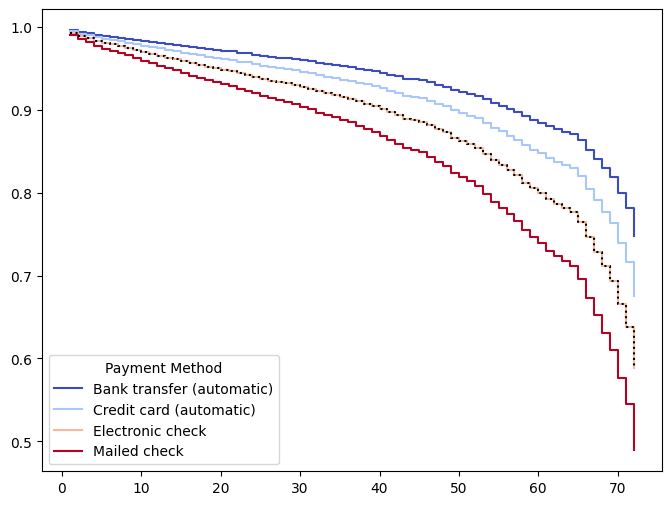

In [25]:
# Payment Method のカテゴリごとの生存曲線を描画
# カテゴリ変数に対応するラベル
payment_mapping = {
    'Bank transfer (automatic)': 0,
    'Credit card (automatic)': 1,
    'Electronic check': 2,
    'Mailed check': 3,
}

# 対応するカテゴリ名と数値のリストを作成
labels, values = zip(*payment_mapping.items())

# プロット
fig, ax = plt.subplots(figsize=(8, 6))
cph.plot_partial_effects_on_outcome(covariates='Payment Method', values=values, cmap='coolwarm', ax=ax)

# 凡例を設定（元のカテゴリ名を表示）
ax.legend(labels, title="Payment Method")

plt.show()

生存曲線の縦軸は生存率（今回はサービス継続率）、横軸は時間（月）を表しています。  
銀行振込 (自動)、クレジットカード (自動)、電子小切手、郵送小切手の順番で解約しづらいことが分かります。  
支払方法で郵送小切手を選択している人は約35か月で当初の1割が解約していることがグラフから分かります。  
このことから3年以内に顧客に郵送小切手から自動の支払い方法に切り替えさせると顧客が得をするキャンペーンを組むことで解約を回避できる可能性が考えられます。

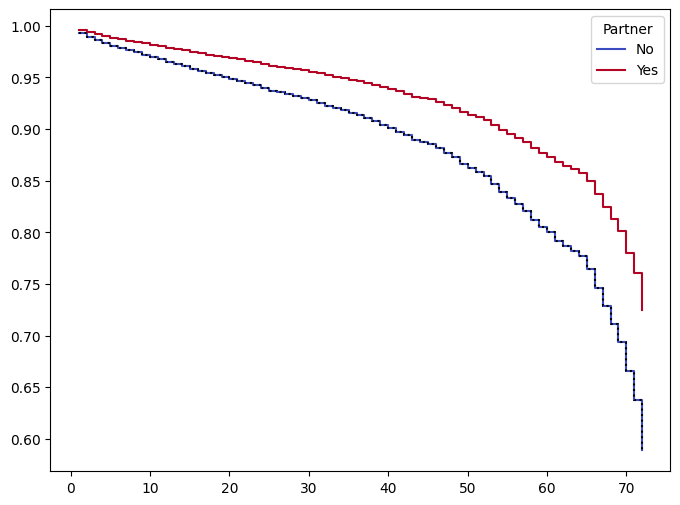

In [26]:
# Payment Method のカテゴリごとの生存曲線を描画
# カテゴリ変数に対応するラベル
partnaer_mapping = {
    'No': 0,
    'Yes': 1,
}

# 対応するカテゴリ名と数値のリストを作成
labels, values = zip(*partnaer_mapping.items())

# プロット
fig, ax = plt.subplots(figsize=(8, 6))
cph.plot_partial_effects_on_outcome(covariates='Partner', values=values, cmap='coolwarm', ax=ax)

# 凡例を設定（元のカテゴリ名を表示）
ax.legend(labels, title="Partner")

plt.show()

2つの生存曲線の結果より、  
支払い方法のカテゴリについては、銀行振込 (自動)、クレジットカード (自動)、電子小切手、郵送小切手の順番で解約しづらいことが分かります。  
顧客にパートナーがいる方が解約はしづらいことが分かります。  

言い換えると、**支払い方法で手動を選択している人の方が**、毎月の支出を気にして**解約しやすく、**  
**パートナーのいない人の方が**節約を気にしてか**解約しやすい**とも言えます。  

**このことから、支払い方法を手動を選択している人、パートナーのいない人にサービスを解約させないためには、これらの人を狙った割引などをイベントとして打ち出していく必要があると考えられます。**  
例えば、支払い方法を手動から銀行振り込み（自動）に切り替えた翌月は支払い額を0とするといった施策です。  

### 機会学習（ランダムフォレスト）  
ランダムフォレストを用いて分類モデルを実行します。  

特徴量「Tenure Months」（契約期間）と「Churn Reason」（解約理由）で分類しても、解約理由は求められないので解析するデータフレームからカラムを削除します。

In [27]:
surv_df = surv_df.drop(columns=['Tenure Months', 'Churn Reason'])

In [28]:
print(surv_df.columns)

Index(['Monthly Charges', 'Churn Score', 'CLTV', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Paperless Billing', 'Payment Method', 'Churn Label'],
      dtype='object')


In [29]:
# 特徴量とターゲット変数の分割
X = surv_df.drop(columns=['Churn Label'])  # 顧客IDやターゲットラベルは特徴量から除外
y = surv_df['Churn Label']  # 予測対象（解約ラベル）

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ランダムフォレストモデルを作成
rf = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# モデルの予測
y_pred = rf.predict(X_test)

# モデルの評価
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 91.40%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1012
           1       0.90      0.78      0.84       395

    accuracy                           0.91      1407
   macro avg       0.91      0.87      0.89      1407
weighted avg       0.91      0.91      0.91      1407

Confusion Matrix:
[[978  34]
 [ 87 308]]


In [ ]:
# 特徴量の重要度の可視化（plotly）
fig = px.bar(x=X.columns, y=importances[indices], labels={'x': 'Feature', 'y': 'Importance'})
fig.update_layout(title="Feature Importance", xaxis_tickangle=-45)
fig.show()

特徴量の重要度を可視化してMonthly Charges（顧客に毎月請求される金額）が重要そうだと分かります。

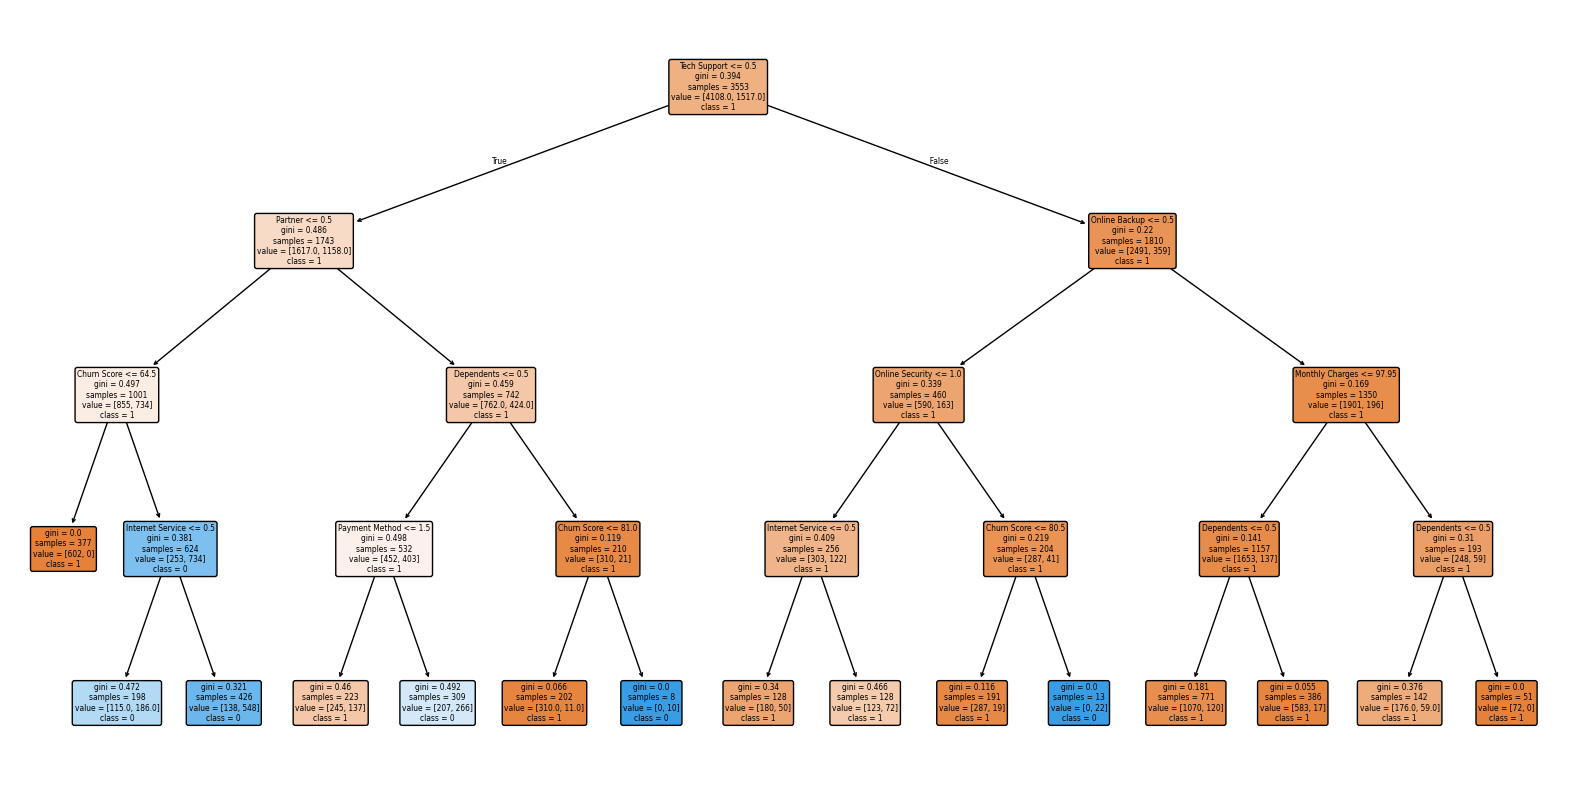

In [31]:
# ランダムフォレストから一つの決定木を取得
tree = rf.estimators_[0]

# 'Churn Label'のユニークな値を取得して文字列に変換
class_names = surv_df['Churn Label'].unique().astype(str)

# 決定木の可視化
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X.columns, class_names=class_names, rounded=True)
plt.show()

各カテゴリは「1=はい、0=いいえ」となっています。  

**1番上のノード**  
Tech supportが0.5以下の時解約する、で分類しています。  
つまり、Tech supportを受けていない程、解約しやすいと解釈できます。  
**2番目のノード（左）**  
パートナーが0.5以下の時解約する、で分類しているのでパートナーがいない程解約しやすいと解釈できます。  
**2番目のノード（右）**  
Online supportが0.5以下の時解約する、で分類しているのでオンラインバックアップを受けていない人ほど解約しやすいと解釈できます。  
それ以降のノードの分類も同様に解釈していきます。

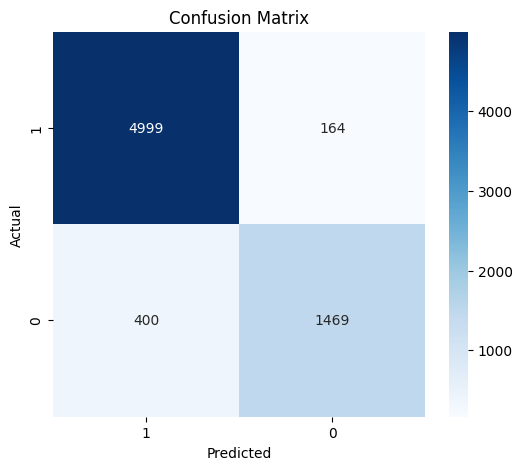

In [32]:
# 予測
y_pred = rf.predict(X)

# 混同行列を計算
cm = confusion_matrix(y, y_pred)

# 混同行列のヒートマップを描画
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


ランダムフォレストの決定木の結果から、  
Tech support（技術サポートサービス）、パートナー、Online support（オンラインサポートサービス）それぞれの有無により解約するかどうか分類できることが分かりました。  
技術サポートサービス、オンラインサポートサービスの価格を下げるキャンペーンを打ち出すことで、顧客にサービスを解約させずに長く利用してもらう工夫になると考えられます。

**生存時間解析、ランダムフォレストの結果から  
支払い方法で手動を選択している人、パートナーのいない人、技術サポートサービス、オンラインサポートサービスをつけていない人を狙った割引などをイベントとして打ち出していく必要があると考えられます。**